In [153]:
%matplotlib inline
import sys, os, subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
from statistics import mean
from pprint import pprint
from collections import defaultdict

df = pd.read_csv("C:/map/AquaMark/pcap_analysis/tshark_PDML/mozark_pcap_analysis-master/logs/trace.log", sep="|", low_memory=False)
df["frame.time"] = pd.to_datetime(df["frame.time"])

other_col_names = [
    'frame.number', 'ip.version', 'ip.proto', 'ip.src', 'ip.dst', 'ip.flags'
]

tcp_col_names = [ 'frame.time', 'frame.time_relative',
    'tcp.stream', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.time_relative',
    'tls.record.content_type', 'tls.handshake.type', 'tls.alert_message',
    'tls.handshake.cert_type.type', 'tls.handshake.extensions_server_name',
    'tls.handshake.extensions_alpn_str',
    'http.response.code', 'http.request.full_uri', 'http.request.uri', 'http.time'
]

udp_col_names = [ 'frame.time', 'frame.time_relative',
    'udp.stream', 'udp.dstport', 'udp.srcport',
    'dns.flags', 'dns.time', 'dns.count.queries', 'dns.qry.name', 'dns.resp.ttl'
]


In [154]:
#Clean Data

# convert tls.record.content_type into one value
for indx_num in df.index:
    for col_name in ["tls.record.content_type"]:
        if(df.loc[indx_num, col_name] == df.loc[indx_num, col_name]):
            df.loc[indx_num, col_name] = int(str(df.loc[indx_num, col_name]).split(',')[0])
            
df_weird_packets = df[ (df['ip.version']=='4,4') | (df['ip.version']=='6,6')]
#print("Number of such packets with ICMP and UDP/DNS = ", len(df_weird_packets))

for indx_num in df_weird_packets.index:
    for col_name in ["ip.version", "ip.proto", "ip.src", "ip.dst", "ip.flags", "ip.frag_offset", "ip.ttl", "ip.len"]:
        df.loc[indx_num, col_name] = df.loc[indx_num, col_name].split(",")[-1]
        df.loc[indx_num, "tls.record.content_type"]

#df['tls.record.content_type'].unique()
df['ip.version'] = df['ip.version'].astype(float)
df['ip.proto'] = df['ip.proto'].astype(float)
df['ip.len'] = df['ip.len'].astype(float)

df_tcp = df[df["tcp.time_relative"].notnull()]
df_dns = df[df["dns.time"].notnull() ]

In [155]:
df['tls.record.content_type'].unique()

array([nan, 23, 22, 20, 21], dtype=object)

In [156]:
len(df)

458631

In [157]:
# Average DNS Lookup Time
dns_time_ = df_dns.groupby(['dns.qry.name'])[['dns.time']].mean().reset_index()

#Concurrent TCP Connection
counter_tcp_concurrent = 0
stream_set = set()
stream_set_del = set()
tcp_concurrent = defaultdict(list)
for index, row in df_tcp.sort_values(by='frame.time', ascending=True).iterrows():
    if(row["tcp.flags.fin"] == 0):
        if(row["tcp.stream"] in stream_set):
            counter_tcp_concurrent = counter_tcp_concurrent
        else:
            if(row["tcp.stream"] not in stream_set_del):
                stream_set.add(row["tcp.stream"])
                counter_tcp_concurrent = counter_tcp_concurrent + 1 
   
    elif(row["tcp.flags.fin"] == 1):
        if(row["tcp.stream"] in stream_set):
            stream_set_del.add(row["tcp.stream"])
            stream_set.remove(row["tcp.stream"]) #thisset.discard("banana") : Note: If the item to remove does not exist, remove() will raise an error.
            counter_tcp_concurrent = counter_tcp_concurrent - 1
        else:
            stream_set.add(row["tcp.stream"])
            #counter_tcp_concurrent = counter_tcp_concurrent + 1
    tcp_concurrent["frame.time"].append(row["frame.time"])
    tcp_concurrent["tcp.stream"].append(row["tcp.stream"])
    tcp_concurrent["tcp.flag.fin"].append(row["tcp.flags.fin"])
    tcp_concurrent["tcp_concurrent_counter"].append(counter_tcp_concurrent)
    
    
df_tcp_concurrent = pd.DataFrame(tcp_concurrent).set_index('frame.time')
#df_tcp_concurrent.head()

df_tcp_concurrent_final = df_tcp_concurrent.resample('100L')['tcp_concurrent_counter'].max().reset_index()
# Average Concurrent TCP Connection
#df_tcp_concurrent_final['tcp_concurrent_counter'].mean()

#no of zombie connection
counter_zombie = 0
for stream, row in df_tcp.groupby("tcp.stream"):
    #len(row.loc[row["tcp.len"] == row["tcp.hdr_len"]]) == len(row)
    if((len(row.loc[row["tcp.len"] == row["tcp.hdr_len"]])) == len(row)):
        counter_zombie = counter_zombie + 1


# TLS Handshake Time | TCP Handshake Time
gp_tcp = df_tcp.groupby("tcp.stream")
tcp_dict = defaultdict(list)
for stream, row in gp_tcp:
    
    stream_time = row.iloc[0]["frame.time"]
    #tcp_len = row.iloc[0]["frame.len"]
    t_tcp_start, t_tls_start, tls_esni, tls_data_proto, t_data_ttfb, t_data_end = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    # TCP handshake time start; assume first frame in stream is start of stream
    t_tcp_start = row.iloc[0]["frame.time_relative"]
    
    if len(row.loc[row["tls.handshake.type"]=="1"])>0:
        # if TLS, TCP handshake time ends when first TLS packet is generated
        # if multiple HELLOs, we end up using the first one, but this shouldn't really happen in a single tcp.stream
        
        # first CLIENT HELLO packet should contain server name and protocol
        tls_client_hello_packet = row.loc[row["tls.handshake.type"]=="1"].iloc[0]
        t_tls_start = tls_client_hello_packet["frame.time_relative"]
        
        # Extract the server name and the DATA protocol (usually http/1.1) from TLS CLIENT HELLO PACKET
        tls_esni = tls_client_hello_packet["tls.handshake.extensions_server_name"]
        tls_data_proto = tls_client_hello_packet["tls.handshake.extensions_alpn_str"]
        
        if len(row.loc[row["tls.record.content_type"]==23])>0:
            #print("yes")
            # if TLS has actual DATA, find the time taken for the complete DATA block
            # TODO: Special Case of multiple DATA blocks in the same stream with large gaps in the middle.
            data_block = row.loc[row["tls.record.content_type"]==23]
            t_data_ttfb = data_block.iloc[0]["frame.time_relative"]
            t_data_end = data_block.iloc[-1]["frame.time_relative"]
            
            num_pkts = len(row.iloc[data_block.index[0]:data_block.index[-1]])
            if len(data_block) < num_pkts:
                print("Number of extra packets in stream %d: (%d - %d) = %d" %(stream, num_pkts, len(data_block), num_pkts-len(data_block)))
                
        else:
            pass
    
    else: 
        # should be only TCP (maybe with a TLS Encrypted Alert to end the connection)
        if len(row[~row["http.response.code"].isnull()])>0:
            # check for HTTP
            t_data_ttfb = row[~row["http.response.code"].isnull()].iloc[0]["frame.time_relative"]
            t_data_end = row[~row["http.response.code"].isnull()].iloc[-1]["frame.time_relative"]
        else:
            # if no HTTP but there was only TCP signalling with no real data => don't count in waterfall
            # there may be a TLS encrypted alert - should not count in waterfall
            pass
    
    # update with values or nan as needed
    #tcp_dict["tcp.len"].append(stream_time)
    tcp_dict["frame.time"].append(stream_time)
    
    tcp_dict["tcp.stream"].append(stream)
    tcp_dict["server"].append(tls_esni)
    tcp_dict["tls_data_proto"].append(tls_data_proto)
    
    tcp_dict["t_tcp_start"].append(t_tcp_start)
    tcp_dict["t_tls_start"].append(t_tls_start)
    tcp_dict["tcp_handshake_time"].append(t_tls_start-t_tcp_start)
    tcp_dict["t_data_ttfb"].append(t_data_ttfb)
    tcp_dict["tls_handshake_time"].append(t_data_ttfb-t_tls_start)
    tcp_dict["t_data_end"].append(t_data_end)
    tcp_dict["data_download_time"].append(t_data_end-t_data_ttfb)


df_tcp_time = pd.DataFrame(tcp_dict)
df_tcp_time.head(10)

frame.time  tcp.stream                        server  \
0 2020-01-30 11:23:33.297567         0.0                           NaN   
1 2020-01-30 11:23:35.072772         1.0                           NaN   
2 2020-01-30 11:24:02.909286         2.0                           NaN   
3 2020-01-30 11:24:03.212756         3.0                           NaN   
4 2020-01-30 11:24:04.491936         4.0  api-prod.vesta-solutions.net   
5 2020-01-30 11:24:18.147672         5.0                           NaN   
6 2020-01-30 11:25:01.396292         6.0                           NaN   
7 2020-01-30 11:25:04.261348         7.0  api-prod.vesta-solutions.net   
8 2020-01-30 11:26:04.286712         8.0  api-prod.vesta-solutions.net   
9 2020-01-30 11:27:04.011517         9.0  api-prod.vesta-solutions.net   

   tls_data_proto  t_tcp_start  t_tls_start  tcp_handshake_time  t_data_ttfb  \
0             NaN     3.122473          NaN                 NaN          NaN   
1             NaN     4.897678          NaN                 NaN     4.924211   
2             NaN    32.734192          NaN                 NaN          NaN   
3             NaN    33.037662          NaN                 NaN          NaN   
4             NaN    34.316842    34.323254            0.006412    34.346930   
5             NaN    47.972578          NaN                 NaN          NaN   
6             NaN    91.221198          NaN                 NaN          NaN   
7             NaN    94.086254    94.090642            0.004388    94.420906   
8             NaN   154.111618   154.116948            0.005330   154.143931   
9             NaN   213.836423   213.841506            0.005083   213.867474   

   tls_handshake_time  t_data_end  data_download_time  
0                 NaN         NaN                 NaN  
1                 NaN    4.924211            0.000000  
2                 NaN         NaN                 NaN  
3                 NaN         NaN                 NaN  
4            0.023676   34.365603            0.018673  
5                 NaN         NaN                 NaN  
6                 NaN         NaN                 NaN  
7            0.330264   94.441025            0.020119  
8            0.026983  154.190139            0.046208  
9            0.025968  213.915748            0.048274

In [164]:
print("Avg DNS Lookup Time ", dns_time_["dns.time"].mean(skipna = True) )
print("Avg TCP Handshake Time : ", df_tcp_time["tcp_handshake_time"].mean(skipna = True))
print("Avg TLS Handshake Time : ", df_tcp_time["tls_handshake_time"].mean(skipna = True))
print("Avg Time to First Byte : ", df_tcp_time["t_data_ttfb"].mean(skipna = True))
print("Avg Data Download Time : ", df_tcp_time["data_download_time"].mean(skipna = True))
print("Avg Data Download Rate : ", "")
print("TCP Payload TCP % : ", len(df_tcp[df_tcp['tcp.len'] > df_tcp['tcp.hdr_len']]) / len(df_tcp) * 100)
print("Max TCP Window Size : ", df_tcp["tcp.window_size"].max(skipna = True))
print("Average TCP Window Size : ", df_tcp["tcp.window_size"].mean(skipna = True))

print("Average Number Of Concurrent TCP Connection : ", df_tcp_concurrent_final["tcp_concurrent_counter"].mean(skipna = True))

print("IPv6 % (by number of packets) : ", len(df[df['ip.version']==6]) / len(df[df['ip.version'].notnull()]) * 100)
print("IPv6 % (by number of bytes) : ", df[df['ip.version']==6]["ip.len"].sum() / df[df['ip.version'].notnull()]["ip.len"].sum() * 100)

print("IPv4 % (by number of packets) : ", len(df[df['ip.version']==4]) / len(df[df['ip.version'].notnull()]) * 100)
print("IPv4 % (by number of bytes) : ", df[df['ip.version']==4]["ip.len"].sum() / df[df['ip.version'].notnull()]["ip.len"].sum() * 100)

print("UDP % (as % of UDP + TCP) : ", len(df[df['ip.proto']==17])/len(df[ (df['ip.proto']==6) | (df['ip.proto']==17) ]) * 100 )
print("DNS as % of UDP : ", len(df[ (df['ip.proto']==17) & ((df['udp.srcport']==53) | (df['udp.dstport']==53)) ]) / len(df[df['ip.proto']==17]) * 100 )



Avg DNS Lookup Time  0.022234299423892632
Avg TCP Handshake Time :  0.009036860960731773
Avg TLS Handshake Time :  0.09152841711746548
Avg Time to First Byte :  76225.84460006257
Avg Data Download Time :  0.1278730498194254
Avg Data Download Rate :  
TCP Payload TCP % :  41.62911081826852
Max TCP Window Size :  1073725440.0
Average TCP Window Size :  157194.60610406913
Average Number Of Concurrent TCP Connection :  153.20253164556962
IPv6 % (by number of packets) :  0.2886852393318376
IPv6 % (by number of bytes) :  0.0
IPv4 % (by number of packets) :  99.71131476066816
IPv4 % (by number of bytes) :  100.0
UDP % (as % of UDP + TCP) :  66.21605334553334
DNS as % of UDP :  5.171132887082754


In [160]:
df_dns_time = df_dns[["dns.qry.name", "frame.time_relative", "frame.time", "dns.time"]].copy()
df_dns_time["t_dns_start"] = df_dns_time["frame.time_relative"] - df_dns_time["dns.time"]
df_dns_time.rename(columns={"frame.time_relative":"t_dns_end",
                            "dns.time": "dns_query_time",
                            "dns.qry.name": "server"}, inplace=True)        
# Merged Waterfall Data        

df_waterfall = pd.merge_asof(df_tcp_time,df_dns_time,
              on='frame.time', by="server",
              tolerance=pd.Timedelta('1000ms')).sort_values(by="frame.time")

df_waterfall["dns_tcp_delta_time"] = df_waterfall["t_tcp_start"] - df_waterfall["t_dns_end"]

# set it to t_dns_start if it exists
df_waterfall["t_start"] = df_waterfall[["t_tcp_start","t_dns_start"]].min(axis=1)

#t_cap_start = df_waterfall.iloc[0]["frame.time"]
#df_waterfall["t_start"] = pd.to_timedelta(df_waterfall["frame.time"] - t_cap_start).dt.total_seconds()

#df_waterfall.head(10)


df_waterfall_filtered = df_waterfall[ df_waterfall["server"].notnull() ]
#df_waterfall_filtered

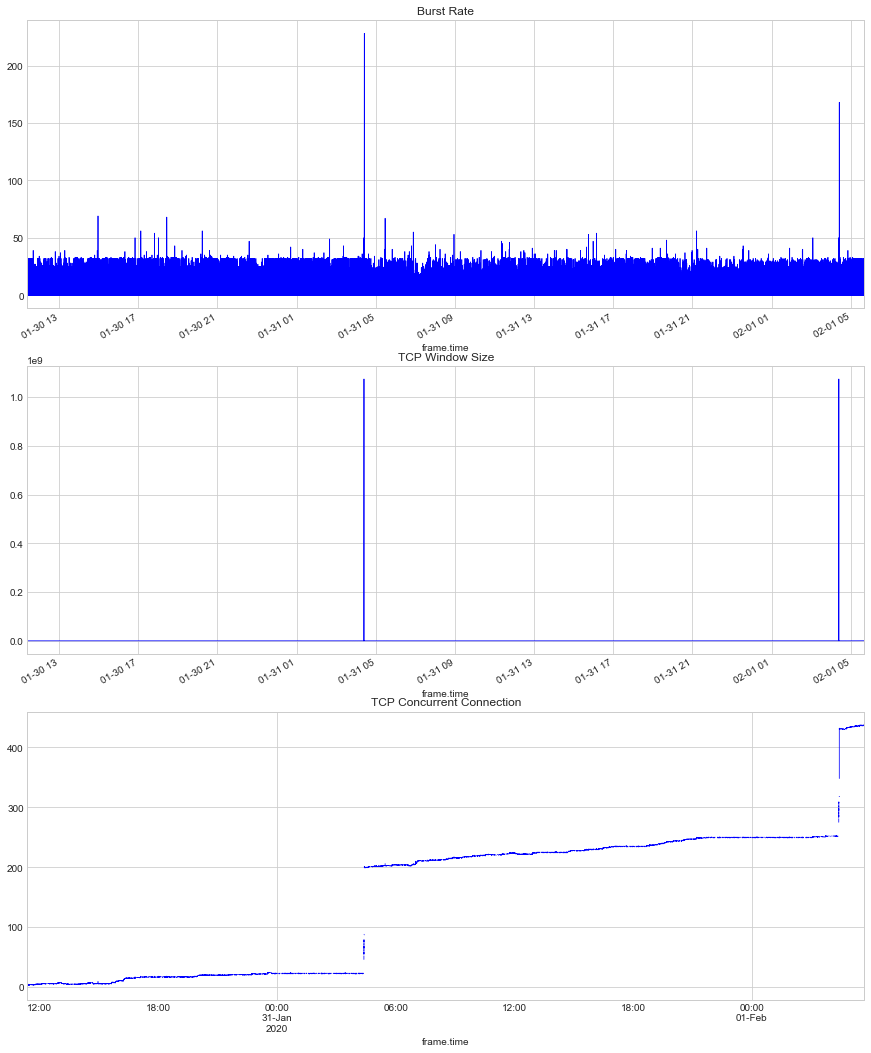

In [161]:
#plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,20),squeeze=False)
ax00 = axes[0][0]
ax10 = axes[1][0]
ax20 = axes[2][0]

# Burst Rate
df_pkt_rate = df[['frame.time', 'frame.len']].set_index('frame.time')
#df_pkt_rate.tz_localize(None)
df_pkt_rate['frame.len'].resample('100L').count().plot(title = "Burst Rate", kind='line', ax=ax00, c='blue', lw=0.75);

# TCP Window Size
df_tcp_window_size = df_tcp[['frame.time', 'tcp.stream', 'tcp.window_size']].set_index('frame.time')
df_tcp_window_size['tcp.window_size'].resample('100L').max().dropna().plot(title = "TCP Window Size", kind='line', ax=ax10, c='blue', lw=0.75);

# TCP Concurrent Connection
df_tcp_concurrent.resample("100L")["tcp_concurrent_counter"].max().plot(title = "TCP Concurrent Connection", kind='line', ax=ax20, c='blue', lw=0.75);

#plt.show()

In [168]:
len(df_waterfall_filtered)

3143

# Waterfall :

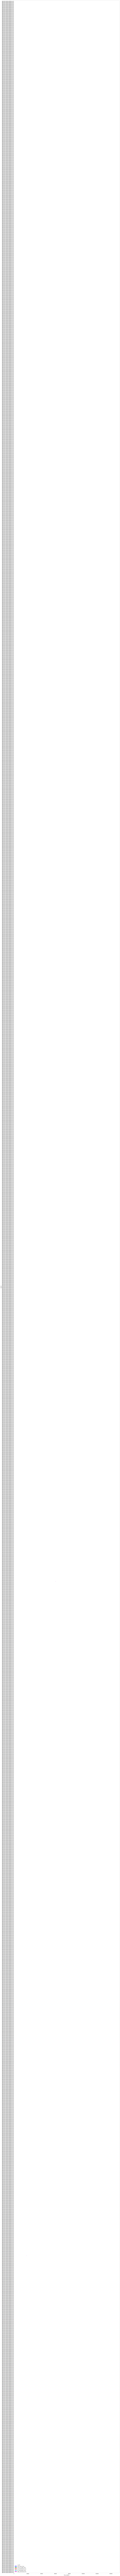

In [166]:
fig, ax = plt.subplots(figsize=(20, 500))
df_waterfall_filtered.plot(kind="barh", x=("server"),
                           y=["t_start", "dns_query_time", "dns_tcp_delta_time", 
                              "tcp_handshake_time", "tls_handshake_time", "data_download_time"],
                           stacked=True, alpha=.7, color=["#FFFFFF", 'b','g','r','c','m'], ax=ax)
ax.set_xlabel("time_relative")
ax.set_ylabel("server")
ax.grid()